# MXNet: Building a Neural Network

## Automatic differentiation with autograd

We train models to get better and better as a function of experience. <br/>
__Usually, getting better means minimizing a loss function__. To achieve this goal, we often iteratively compute the gradient of the loss with respect to weights and then update the weights accordingly. While the gradient calculations are straightforward through a chain rule, for complex models, working it out by hand can be a pain.<br/>
__Before diving deep into the model training, let’s go through how MXNet’s autograd package expedites this work by automatically calculating derivatives.__

__Basic usage__

## Sample Problem: Detecting Electrical Plugs in Amazon Marketplace Products
#### In this notebook, we will explore an Amazon dataset. In some marketplaces, ASINs having electrical plugs need to be accompanied by a compliance form. Thus it is desirable to identify ASINs which have an electrical plug.

__Dataset schema:__ 
- __ASIN__: Product ASIN
- __target_label:__ Binary field with values in {0,1}. A value of 1 show ASIN has a plug, otherwise 0.
- __ASIN_STATIC_ITEM_NAME:__ Title of the ASIN.
- __ASIN_STATIC_PRODUCT_DESCRIPTION:__ Description of the ASIN
- __ASIN_STATIC_GL_PRODUCT_GROUP_TYPE:__ GL information for the ASIN.
- __ASIN_STATIC_ITEM_PACKAGE_WEIGHT:__ Weight of the ASIN.
- __ASIN_STATIC_LIST_PRICE:__ Price information for the ASIN.
- __ASIN_STATIC_BATTERIES_INCLUDED:__ Information whether batteries are included along with the product.
- __ASIN_STATIC_BATTERIES_REQUIRED:__ Information whether batteries are required for using the product.
- __ASIN_STATIC_ITEM_CLASSIFICATION:__ Item classification of whether it is a standalone or bundle parent item etc

## 1. Reading the data
Let's read the dataset into a dataframe.

In [2]:
import pandas as pd

# import the datasets
df = pd.read_csv('C:\\Users\\solharsh\\Downloads\\Tabular Data MLU\\final_project\\final_project\\asin_product.csv',encoding= 'unicode_escape')

C:\Users\solharsh\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,18,19,23,31,38,41,48,63,78,82,85,96,105) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Overall Statistics and Imputing:
We will look at number of rows, columns and simple statistics of the dataset.

In [30]:
df["ASIN_STATIC_ITEM_CLASSIFICATION"].unique()

array(['base_product', nan, 'variation_parent'], dtype=object)

In [31]:
df['target_label'].value_counts()

0    58989
1     2244
Name: target_label, dtype: int64

In [32]:
# Print the first five rows
# NaN means missing data
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED,ASIN_STATIC_BATTERIES_REQUIRED,ASIN_STATIC_ITEM_CLASSIFICATION
0,B004U9MOWO,0,Master Lock 8 X 900 mm Chain Integrated 4 Digi...,Master Lock Street Flexium 900mm Integrated Co...,gl_sports,2.650000,16.66,False,False,base_product
1,B006OJWZMW,0,In Phase SRX-EQ 10 Band Parametric Equalizer w...,NaN,gl_wireless,1.680000,158.33,False,False,base_product
2,B00008VIJ4,0,Technics RPDJ1210 DJ Headphones - Silver,"Plated Connector:Gold, Connector Type:Headphon...",gl_home_entertainment,1.455036,NaN,False,False,base_product
3,B005433T4M,0,"Heartwarmers Coming Home Padded Lap Tray, 42 x...",NaN,gl_home,1.763680,12.49,False,NaN,base_product
4,B0073CN63Q,0,"Douceur D'Intérieur - 1600728, Curtain With E...",NaN,gl_home,2.292784,25.42,False,False,base_product


In [33]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61233 entries, 0 to 61232
Data columns (total 10 columns):
ASIN                                 61233 non-null object
target_label                         61233 non-null int64
ASIN_STATIC_ITEM_NAME                61233 non-null object
ASIN_STATIC_PRODUCT_DESCRIPTION      35261 non-null object
ASIN_STATIC_GL_PRODUCT_GROUP_TYPE    61233 non-null object
ASIN_STATIC_ITEM_PACKAGE_WEIGHT      61141 non-null float64
ASIN_STATIC_LIST_PRICE               45741 non-null float64
ASIN_STATIC_BATTERIES_INCLUDED       50058 non-null object
ASIN_STATIC_BATTERIES_REQUIRED       45229 non-null object
ASIN_STATIC_ITEM_CLASSIFICATION      61221 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 4.7+ MB


In [34]:
# This will print basic statistics for numerical columns
df.describe()

,target_label,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE
count,61233.000000,61141.000000,4.574100e+04
mean,0.036647,31.520023,1.475785e+02
std,0.187895,462.639041,1.664631e+04
min,0.000000,0.000000,1.160000e+00
25%,0.000000,1.520000,1.667000e+01
50%,0.000000,2.513244,3.291000e+01
75%,0.000000,5.555592,7.000000e+01
max,1.000000,29500.000000,3.560000e+06


Let's check our target distribution.

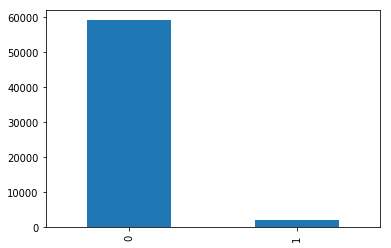

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt


df['target_label'].value_counts().plot.bar()
plt.show()

We can see from the target plot above that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). In this case, we have a lot of "no plug" records but not many "plug" records.

In [36]:
df['ASIN_STATIC_LIST_PRICE'].value_counts(bins=10, sort=False)

(-3558.84, 356001.044]        45740
(356001.044, 712000.928]          0
(712000.928, 1068000.812]         0
(1068000.812, 1424000.696]        0
(1424000.696, 1780000.58]         0
(1780000.58, 2136000.464]         0
(2136000.464, 2492000.348]        0
(2492000.348, 2848000.232]        0
(2848000.232, 3204000.116]        0
(3204000.116, 3560000.0]          1
Name: ASIN_STATIC_LIST_PRICE, dtype: int64

We have an outlier data in the last bin. We will remove this data point below.

In [37]:
dropIndexes = df[df['ASIN_STATIC_LIST_PRICE'] > 3000000].index
df.drop(dropIndexes , inplace=True)

In [38]:
df['ASIN_STATIC_LIST_PRICE'].value_counts(bins=10, sort=False)

(-13.838999999999999, 1500.944]    45704
(1500.944, 3000.728]                  15
(3000.728, 4500.512]                   9
(4500.512, 6000.296]                   3
(6000.296, 7500.08]                    2
(7500.08, 8999.864]                    4
(8999.864, 10499.648]                  0
(10499.648, 11999.432]                 1
(11999.432, 13499.216]                 0
(13499.216, 14999.0]                   2
Name: ASIN_STATIC_LIST_PRICE, dtype: int64

Let's look at missing values for each column in our dataset.

In [39]:
df.isna().sum()

ASIN                                     0
target_label                             0
ASIN_STATIC_ITEM_NAME                    0
ASIN_STATIC_PRODUCT_DESCRIPTION      25972
ASIN_STATIC_GL_PRODUCT_GROUP_TYPE        0
ASIN_STATIC_ITEM_PACKAGE_WEIGHT         92
ASIN_STATIC_LIST_PRICE               15492
ASIN_STATIC_BATTERIES_INCLUDED       11175
ASIN_STATIC_BATTERIES_REQUIRED       16004
ASIN_STATIC_ITEM_CLASSIFICATION         12
dtype: int64

In [40]:
# Numerical fields are imputed with mean values
df["ASIN_STATIC_ITEM_PACKAGE_WEIGHT"].fillna(df["ASIN_STATIC_ITEM_PACKAGE_WEIGHT"].mean(), inplace=True)
df["ASIN_STATIC_LIST_PRICE"].fillna(df["ASIN_STATIC_LIST_PRICE"].mean(), inplace=True)

# Categorical values are imputed with a placeholder value
df["ASIN_STATIC_PRODUCT_DESCRIPTION"].fillna("Missing", inplace=True)
df["ASIN_STATIC_BATTERIES_INCLUDED"].fillna("Missing", inplace=True)
df["ASIN_STATIC_BATTERIES_REQUIRED"].fillna("Missing", inplace=True)
df["ASIN_STATIC_ITEM_CLASSIFICATION"].fillna("Missing", inplace=True)

Let's check missing values one more time

In [41]:
df.isna().sum()

ASIN                                 0
target_label                         0
ASIN_STATIC_ITEM_NAME                0
ASIN_STATIC_PRODUCT_DESCRIPTION      0
ASIN_STATIC_GL_PRODUCT_GROUP_TYPE    0
ASIN_STATIC_ITEM_PACKAGE_WEIGHT      0
ASIN_STATIC_LIST_PRICE               0
ASIN_STATIC_BATTERIES_INCLUDED       0
ASIN_STATIC_BATTERIES_REQUIRED       0
ASIN_STATIC_ITEM_CLASSIFICATION      0
dtype: int64

## 3. Processing Categorical Variables

Our categorical variables are __ASIN_STATIC_BATTERIES_INCLUDED__, __ASIN_STATIC_BATTERIES_REQUIRED__ and __ASIN_STATIC_ITEM_CLASSIFICATION__. It is a good idea to check the unique values for these columns.

In [42]:
df['ASIN_STATIC_BATTERIES_INCLUDED'].value_counts()

False      48123
Missing    11175
True        1934
Name: ASIN_STATIC_BATTERIES_INCLUDED, dtype: int64

In [43]:
df['ASIN_STATIC_BATTERIES_REQUIRED'].value_counts()

False      42415
Missing    16004
True        2813
Name: ASIN_STATIC_BATTERIES_REQUIRED, dtype: int64

In [44]:
df['ASIN_STATIC_ITEM_CLASSIFICATION'].value_counts()

base_product        61199
variation_parent       21
Missing                12
Name: ASIN_STATIC_ITEM_CLASSIFICATION, dtype: int64

In [45]:
df['ASIN_STATIC_GL_PRODUCT_GROUP_TYPE'].value_counts()

gl_home                        16221
gl_home_improvement             6985
gl_sports                       5868
gl_toy                          5493
gl_automotive                   4435
gl_pet_products                 4231
gl_office_product               3229
gl_lawn_and_garden              2779
gl_musical_instruments          2008
gl_pc                           1837
gl_camera                       1789
gl_electronics                  1440
gl_baby_product                 1375
gl_drugstore                     857
gl_wireless                      655
gl_personal_care_appliances      643
gl_kitchen                       626
gl_biss                          259
gl_major_appliances              237
gl_home_entertainment            116
gl_apparel                        58
gl_luggage                        34
gl_shoes                          22
gl_beauty                         20
gl_video_games                     7
gl_book                            3
gl_watch                           3
g

We will not use the gl product type field in this example.

In [46]:
df.drop(columns=['ASIN_STATIC_GL_PRODUCT_GROUP_TYPE'], inplace=True)

Let's apply __one-hot-encoding__ to these three columns.

In [47]:
df = pd.get_dummies(df, columns=['ASIN_STATIC_BATTERIES_INCLUDED', 
                                 'ASIN_STATIC_BATTERIES_REQUIRED', 'ASIN_STATIC_ITEM_CLASSIFICATION'])

In [48]:
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED_False,ASIN_STATIC_BATTERIES_INCLUDED_True,ASIN_STATIC_BATTERIES_INCLUDED_Missing,ASIN_STATIC_BATTERIES_REQUIRED_False,ASIN_STATIC_BATTERIES_REQUIRED_True,ASIN_STATIC_BATTERIES_REQUIRED_Missing,ASIN_STATIC_ITEM_CLASSIFICATION_Missing,ASIN_STATIC_ITEM_CLASSIFICATION_base_product,ASIN_STATIC_ITEM_CLASSIFICATION_variation_parent
0,B004U9MOWO,0,Master Lock 8 X 900 mm Chain Integrated 4 Digi...,Master Lock Street Flexium 900mm Integrated Co...,2.650000,16.660000,1,0,0,1,0,0,0,1,0
1,B006OJWZMW,0,In Phase SRX-EQ 10 Band Parametric Equalizer w...,Missing,1.680000,158.330000,1,0,0,1,0,0,0,1,0
2,B00008VIJ4,0,Technics RPDJ1210 DJ Headphones - Silver,"Plated Connector:Gold, Connector Type:Headphon...",1.455036,69.750458,1,0,0,1,0,0,0,1,0
3,B005433T4M,0,"Heartwarmers Coming Home Padded Lap Tray, 42 x...",Missing,1.763680,12.490000,1,0,0,0,0,1,0,1,0
4,B0073CN63Q,0,"Douceur D'Intérieur - 1600728, Curtain With E...",Missing,2.292784,25.420000,1,0,0,1,0,0,0,1,0


## 4. Training, validation, test subsets and Feature Engineering
We will split our dataset into training (80%), test (10%) and validation (10%) subset. Sklearn's "train_test_split()" function is a useful function to use here. More details are available here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [49]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=23)
validation_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=23)

In [50]:
print(sum(train_data['target_label'] == 0))
print(sum(train_data['target_label'] == 1))

47189
1796


__Dataset balancing:__ In this dataset, we have imbalance in terms of number of samples from each class: 47189 samples for class 0 and 1796 samples for class 1. <br/>
This might cause trouble in learning, especially the rare class. <br/>
In order to fix it, we will upsample the rare the class. In the end, we will have equal number of samples for each class. <br/>
__Important note:__ We want to fix the imbalance only in training set. We shouldn't change the validation and test sets, they should follow the original distribution.

In [51]:
from sklearn.utils import shuffle

plug_products = train_data[train_data['target_label'] == 1]
no_plug_products = train_data[train_data['target_label'] == 0]

upsampled_plug_products = plug_products.sample(n=len(no_plug_products), replace=True, random_state=42)

train_data = pd.concat([no_plug_products, upsampled_plug_products])
train_data = shuffle(train_data)

In [52]:
print(sum(train_data['target_label'] == 0))
print(sum(train_data['target_label'] == 1))

47189
47189


__Text Processing:__ 

In this part, we will get Bag of Word feautures for our text fields: __ASIN_STATIC_ITEM_NAME__ and __ASIN_STATIC_PRODUCT_DESCRIPTION__. <br/>
We will use the same functions from yesterday's class.

In [53]:
import re, string

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

In [54]:
%%time
import nltk
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

train_names = [cleanSentence(item, stop_words, stemmer) for item in train_data["ASIN_STATIC_ITEM_NAME"].values]
train_descriptions = [cleanSentence(item, stop_words, stemmer) for item in train_data["ASIN_STATIC_PRODUCT_DESCRIPTION"].values]

validation_names = [cleanSentence(item, stop_words, stemmer) for item in validation_data["ASIN_STATIC_ITEM_NAME"].values]
validation_descriptions = [cleanSentence(item, stop_words, stemmer) for item in validation_data["ASIN_STATIC_PRODUCT_DESCRIPTION"].values]

test_names = [cleanSentence(item, stop_words, stemmer) for item in test_data["ASIN_STATIC_ITEM_NAME"].values]
test_descriptions = [cleanSentence(item, stop_words, stemmer) for item in test_data["ASIN_STATIC_PRODUCT_DESCRIPTION"].values]

# We can also use the max_features parameter here to limit the size of the vocabulary
name_vectorizer = CountVectorizer(binary=True, max_features=50)
desc_vectorizer = CountVectorizer(binary=True, max_features=150)

train_name_features = name_vectorizer.fit_transform(train_names)
train_desc_features = desc_vectorizer.fit_transform(train_descriptions)
print("Train name shapes:", train_name_features.shape, "Train desc shapes:", train_desc_features.shape)

val_name_features = name_vectorizer.transform(validation_names)
val_desc_features = desc_vectorizer.transform(validation_descriptions)
print("Val name shapes:", val_name_features.shape, "Val desc shapes:", val_desc_features.shape)

test_name_features = name_vectorizer.transform(test_names)
test_desc_features = desc_vectorizer.transform(test_descriptions)
print("Test name shapes:", test_name_features.shape, "Test desc shapes:", test_desc_features.shape)


Train name shapes: (94378, 50) Train desc shapes: (94378, 150)
Val name shapes: (6123, 50) Val desc shapes: (6123, 150)
Test name shapes: (6124, 50) Test desc shapes: (6124, 150)
CPU times: user 1min 1s, sys: 151 ms, total: 1min 1s
Wall time: 1min 4s


## 5. Fitting the classifier
We will use Gluon library to build a simple neural network and fit to our training data. This time, we will also use our validation data and check performance at the end of each iteration.

In [55]:
columns = df.columns.tolist()
print(columns)

['ASIN', 'target_label', 'ASIN_STATIC_ITEM_NAME', 'ASIN_STATIC_PRODUCT_DESCRIPTION', 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT', 'ASIN_STATIC_LIST_PRICE', 'ASIN_STATIC_BATTERIES_INCLUDED_False', 'ASIN_STATIC_BATTERIES_INCLUDED_True', 'ASIN_STATIC_BATTERIES_INCLUDED_Missing', 'ASIN_STATIC_BATTERIES_REQUIRED_False', 'ASIN_STATIC_BATTERIES_REQUIRED_True', 'ASIN_STATIC_BATTERIES_REQUIRED_Missing', 'ASIN_STATIC_ITEM_CLASSIFICATION_Missing', 'ASIN_STATIC_ITEM_CLASSIFICATION_base_product', 'ASIN_STATIC_ITEM_CLASSIFICATION_variation_parent']


In [56]:
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
import mxnet.ndarray as nd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# We will add our bag of words features to all other features here
X_train = np.concatenate((train_data[columns[6:]].values,
                          train_name_features.toarray(),
                          train_desc_features.toarray(),
                         ), axis=1)

y_train = train_data['target_label'].values

# We will add our bag of words features to all other features here
X_val = np.concatenate((validation_data[columns[6:]].values,
                          val_name_features.toarray(),
                          val_desc_features.toarray(),
                         ), axis=1)

y_val = validation_data['target_label'].values

# Set this to CPU or GPU depending on your training instance
# ctx = mx.gpu()
ctx = mx.cpu()

# Hyper-paramaters of the system
batch_size = 16
epochs = 5
learning_rate = 0.01

# Let's set our data loaders
train_dataset = mx.gluon.data.dataset.ArrayDataset(nd.array(X_train), nd.array(y_train))
val_dataset = mx.gluon.data.dataset.ArrayDataset(nd.array(X_val), nd.array(y_val))

train_data_loader = mx.gluon.data.DataLoader(train_dataset, batch_size=16)
val_data_loader = mx.gluon.data.DataLoader(val_dataset, batch_size=16)

# Let's create a simple Multi Layer Perceptron
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(units=64, activation='relu'))
    net.add(gluon.nn.Dropout(.4))
    net.add(gluon.nn.Dense(units=64, activation='relu'))
    net.add(gluon.nn.Dropout(.4))
    net.add(gluon.nn.Dense(units=1, activation='sigmoid'))
    
net.collect_params().initialize(mx.init.Xavier())

# Define loss and trainer.
binary_cross_etropy_loss = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})


# Starting the outer loop, we will have 5 epochs (5 full pass through our dataset)
for epoch in range(epochs):
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    cumulative_train_loss = 0
    train_predictions = []
    for i, (data, label) in enumerate(train_data_loader):
        with autograd.record():
            output = net(data)
            train_predictions += np.squeeze(output.asnumpy()).tolist()
        
            # Let's calculate our loss and add it to our cumulative loss
            loss = binary_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])

    # Calculating the Log-loss for training data
    train_loss = cumulative_train_loss/len(X_train)

    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    
    cumulative_valid_loss = 0
    val_predictions = []
    for i, (data, label) in enumerate(val_data_loader):
        output = net(data)
        val_predictions += np.squeeze(output.asnumpy()).tolist()
        val_loss = binary_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
    
    # Calculating the Log-loss for validation data
    valid_loss = cumulative_valid_loss/len(X_val)
    
    # Round predictions: 0.5 and up becomes 1, 0 otherwise
    train_predictions = [round(train_pred) for train_pred in train_predictions]
    val_predictions = [round(val_pred) for val_pred in val_predictions]

    # Calculate training and validation accuracies
    # accuracy = (TP+TN) / (TP+FP+TN+FN)
    train_accuracy = accuracy_score(y_train, train_predictions)
    validation_accuracy = accuracy_score(y_val, val_predictions)
    validation_report = classification_report(y_val, val_predictions)
    
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, \
    training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, \
                                                                   train_loss.asnumpy()[0], 
                                                                   valid_loss.asnumpy()[0], 
                                                                   train_accuracy, 
                                                                   validation_accuracy))
    print("Classification report \n", validation_report)

Epoch 0, training loss: 0.67, validation loss: 0.61,     training accuracy: 0.58, validation accuracy: 0.77
Classification report 
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      5920
           1       0.06      0.43      0.11       203

   micro avg       0.77      0.77      0.77      6123
   macro avg       0.52      0.60      0.49      6123
weighted avg       0.95      0.77      0.84      6123

Epoch 1, training loss: 0.63, validation loss: 0.58,     training accuracy: 0.65, validation accuracy: 0.78
Classification report 
               precision    recall  f1-score   support

           0       0.98      0.79      0.88      5920
           1       0.07      0.46      0.12       203

   micro avg       0.78      0.78      0.78      6123
   macro avg       0.52      0.63      0.50      6123
weighted avg       0.95      0.78      0.85      6123

Epoch 2, training loss: 0.60, validation loss: 0.56,     training accuracy: 0.67, 

## 6. Testing

Let's see how the classifier performs with "unseen" data (our test data). We will use the predict() function this time.

In [57]:
%%time
# Let's get the input and output data for testing the classifier
X_test = np.concatenate((test_data[columns[6:]].values,
                          test_name_features.toarray(),
                          test_desc_features.toarray(),
                         ), axis=1)

y_test = test_data['target_label'].values

test_input = nd.array(X_test.astype('float32')).as_in_context(ctx)
test_predictions = net(test_input)

# Round predictions: 0.5 and up becomes 1, 0 otherwise
y_pred = [round(test_pred) for test_pred in np.squeeze(test_predictions.asnumpy()).tolist()]

CPU times: user 16.2 ms, sys: 8.28 ms, total: 24.4 ms
Wall time: 23 ms


We will use Sklearn's metrics functions to see the results.

__Confusion matrix:__ The diagonals show us correct classifications. Each row and column belongs to a class (plug or no plug). The first column and row correspond to "no plug" case, the second column-rows are "plug" case.

In [58]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[4814 1065]
 [ 133  112]]


Let's look at the classification report and accuracy below.

In [59]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      5879
           1       0.10      0.46      0.16       245

   micro avg       0.80      0.80      0.80      6124
   macro avg       0.53      0.64      0.52      6124
weighted avg       0.94      0.80      0.86      6124

Accuracy: 0.8043762246897452
